# MyMDB Analyzer
This notebook accesses the IMDb-Scraping pipeline consisting of the webscraper, the database connector and provides a GUI for the interactive visualization.

![IMDb Logo](https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/IMDB_Logo_2016.svg/440px-IMDB_Logo_2016.svg.png)

[Wikipedia IMDb Definition](https://en.wikipedia.org/wiki/IMDb):

IMDb (an acronym for `I`nternet `M`ovie `D`ata`b`ase) is an online database of information related to films, television series, podcasts, home videos, video games, and streaming content online – including cast, production crew and personal biographies [...]

This notebook visually explores rankings of movies and actors and 

#### OVERCOMING TECHNICAL DIFFICULTIES

In [1]:
# workarround for using event_loops in notebooks (ipykernel already uses the global non-reentrant one)
import nest_asyncio
nest_asyncio.apply()

#### Imports

In [2]:
import db
import analyze
import ui

connecting to db via conn_str: DRIVER=SQL Server;SERVER=localhost;PORT=1433;DATABASE=MyMDB;UID=SA;PWD=Pr0dRdyPw!


### SCRAPING
Challenges were respecting the site's scraping rules located in robots.txt, not getting timed out even though we followed through and handling those timeouts as well as handling (rather omitting a ton of) missing/format-inhomogenous data as well as asynchronous caching in python.

In [3]:
movies = []
import_ui = ui.init_ui(movies)
import_ui

100 movies acquired

In [5]:
movies = import_ui.movies

### INSERTION
This part was done purely in the SQL Server Backend, using a stored procedure for parsing the insertion data, and taking care of NaN values and the likes.

A trigger was used to recursively update the average instead of recomputation over several tables for each new insert.

In [6]:
for movie in movies:
    try:
        db.insert_movie(**movie)
    except Exception as e:
        print(f"issue at {movie}\n{e}")
print("no duplicates found" if db.check_no_duplicates() else "duplicates in actors detected")

'no duplicates found'

### READING
For further analysis the movies are queried back from the db and converted to dataframes

In [7]:
df_movies = analyze.get_movie_dataframe()
df_actors = analyze.get_actors_dataframe()
df_movie_actors = analyze.get_movie_actors_dataframe()
df_actor_features = analyze.get_actor_feature_dataframe()
df_movie_features = analyze.get_movie_feature_dataframe()
df_summary = (
 analyze.get_summary_dataframe()
 .sort_values(by="name")
)

display("movies", df_movies.head())
display("actors", df_actors.head())
display("movie_actors", df_movie_actors.head(5))
display("joined data", df_summary.head(10))
display(
    df_summary
    .drop(["movie_id", "actor_id"], axis=1)
    .describe()
)
display("interesting features for actor analysis", df_actor_features.head())
display(df_actor_features.describe())
display("interesting features for movie analysis", df_movie_features.head())
display(df_movie_features.describe())

'movies'

,id,title,year,genre,rating,budget,gross_income
0,573,Die zwölf Geschworenen,1957,Krimi,9.0,350000.0000,955.0000
1,574,Chihiros Reise ins Zauberland,2001,Animation,8.5,19000000.0000,357277400.0000
2,575,GoodFellas - Drei Jahrzehnte in der Mafia,1990,Biografie,8.7,25000000.0000,47036784.0000
3,576,Krieg der Sterne,1977,Action,8.5,11000000.0000,775398007.0000
4,577,Einer flog über das Kuckucksnest,1975,Drama,8.6,3000000.0000,109114817.0000


'actors'

,id,name,age,avg_rating
0,3074,Martin Balsam,103,9.0
1,3075,Edward Binns,106,9.0
2,3076,Walter Stocker,97,9.0
3,3077,John Savoca,-1,9.0
4,3078,Rudy Bond,110,9.1


'movie_actors'

,movie_id,actor_id
0,718,3893
1,718,3894
2,718,3895
3,719,3896
4,719,3897


'joined data'

,name,age,avg_rating,movie_id,actor_id,title,year,genre,rating,budget,gross_income
483,Aaron Eckhart,55,9.0,724,3921,The Dark Knight,2008,Action,9.0,185000000.0000,1006234167.0000
254,Abdo Abdo,-1,8.3,649,3527,Capernaum: Stadt der Hoffnung,2018,Drama,8.3,4000000.0000,64417003.0000
459,Abdullah Abbas,116,8.5,717,3888,Casablanca,1942,Drama,8.5,950000.0000,4627326.0000
9,Abe Vigoda,102,9.2,638,3464,Der Pate,1972,Krimi,9.2,6000000.0000,250341816.0000
146,Absa Diatou Toure,-1,8.5,613,3328,Ziemlich beste Freunde,2011,Biografie,8.5,9500000.0000,426588510.0000
456,Adolphe Menjou,133,8.4,715,3880,Wege zum Ruhm,1957,Drama,8.4,935000.0000,5252.0000
322,Ahn Seong-bong,-1,8.5,664,3616,Parasite,2019,Drama,8.5,11400000.0000,262681282.0000
60,Aidan Gillen,55,8.3,584,3146,The Dark Knight Rises,2012,Action,8.3,250000000.0000,1081169825.0000
299,Al Matthews,80,8.3,659,3586,Aliens - Die Rückkehr,1986,Action,8.3,18500000.0000,131060248.0000
12,Al Pacino,83,9.2,638,3467,Der Pate,1972,Krimi,9.2,6000000.0000,250341816.0000


,age,avg_rating,year
count,532.000000,532.000000,532.000000
mean,60.133459,8.488346,1987.031955
std,43.868652,0.213956,23.140708
min,-1.000000,8.200000,1931.000000
25%,-1.000000,8.300000,1972.000000
50%,64.500000,8.400000,1994.000000
75%,94.250000,8.600000,2003.000000
max,152.000000,9.200000,2023.000000


'interesting features for actor analysis'

,name,age,appearances,avg_rating
0,Sterling Hayden,107,1,9.2
1,Richard S. Castellano,89,1,9.2
2,Neil Giuntoli,63,1,9.2
3,John Marley,115,1,9.2
4,James Whitmore,101,1,9.2


,age,appearances,avg_rating
count,382.000000,382.000000,382.000000
mean,80.751309,1.039267,8.485079
std,29.602412,0.194484,0.222046
min,14.000000,1.000000,8.200000
25%,58.000000,1.000000,8.300000
50%,78.500000,1.000000,8.400000
75%,101.750000,1.000000,8.600000
max,152.000000,2.000000,9.200000


'interesting features for movie analysis'

,year,budget,gross_income,rating
0,1957,350000.0,955.0,9.0
1,2001,19000000.0,357277400.0,8.5
2,1990,25000000.0,47036784.0,8.7
3,1977,11000000.0,775398007.0,8.5
4,1975,3000000.0,109114817.0,8.6


,year,budget,gross_income,rating
count,99.000000,9.900000e+01,9.400000e+01,99.000000
mean,1987.393939,7.883817e+07,3.157266e+08,8.483838
std,23.107918,2.523957e+08,4.482264e+08,0.216044
min,1931.000000,1.522200e+04,9.550000e+02,8.200000
25%,1973.000000,3.500000e+06,2.347496e+07,8.300000
50%,1994.000000,1.900000e+07,1.148744e+08,8.400000
75%,2003.500000,7.000000e+07,4.264600e+08,8.600000
max,2023.000000,2.400000e+09,2.799439e+09,9.200000


### Visualization


c:\Users\NiJoL\anaconda3\envs\MyMDB\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


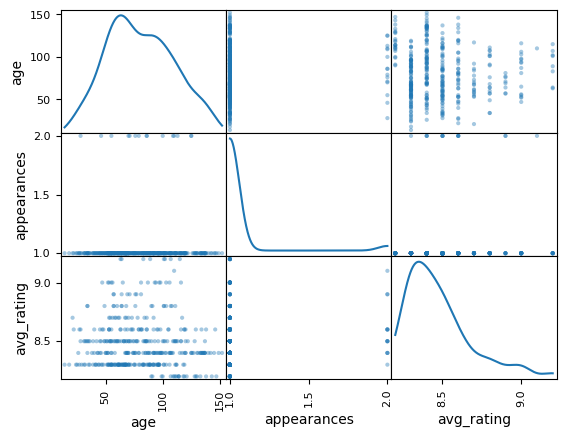

In [8]:
analyze.scattermatrix(
    df_actor_features.drop(df_actor_features[df_actor_features["age"] == -1].index)
)

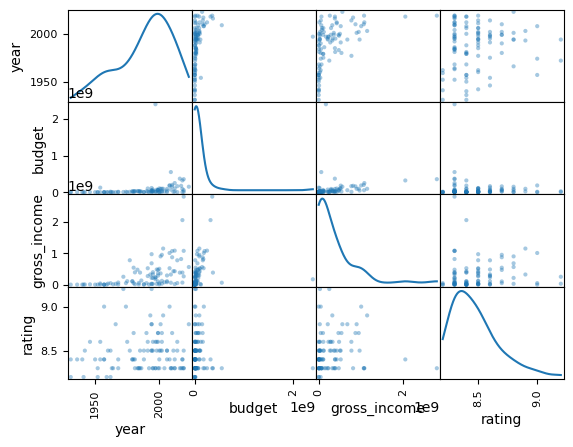

In [9]:
analyze.scattermatrix(
    df_movie_features
)

# outlook

- scrape random movies and try to classify if a given actor could really make it using the top 250 (interesting outliers for certain actors included in top 250 that say only did a single movie)
- try to predict imdb rating